ChEn-5310: Computational Continuum Transport Phenomena Spring 2021 UMass Lowell; Prof. V. F. de Almeida **25Jan21**

# 03. Lagrange Basis Functions Least-Squares Residual
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\fvec}{\boldsymbol{\mathsf{f}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Reals}{\mathbb{R}}
  \newcommand{\thetavec}{\boldsymbol{\theta}}
$

---

## Table of Contents<a id="toc"></a>
* [Objectives](#obj)
* [Target Function](#f)
* [Collocation Points](#colpts)
* [Lagrange Polynomial Basis Functions w/ Least-Squares Residual](#lagrange-lsq)
  - [Linear Combination of Non-Linear Basis Functions](#lagrange-lincomb)
  - [Optimal Combination Coefficients](#lagrange-optimal-coeff)
  - [Best Approximant Function](#lagrange-approximant)
  - [Results](#lagrange-res)
  - [Errors](#lagrange-error)
  - [Residual](#lagrange-residual)
* [Experiment #1](#ex1)
---

## [Objectives](#toc)<a id="obj"></a>

 + Introductory comments on variational forms and basis functions.
 + Elementary use of basis functions to approximate a given function: linear least-squares method
 + Elementary description of a least-squares Galerkin spectral element method to solve 1-D Poisson problem.
 + [Handwritten notes in OneNote](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/EiT9S8dWWQ5LuvalDfeDuOoBs-_tgLPFR83xU6WumdI9xg?e=fQXd40).

## [Target Function](#toc)<a id="f"></a>

Given a *well-behaved* target function $f:[a,b]\rightarrow\Reals$ how can we systematically compute an approximant $g:[a,b]\rightarrow\Reals$? Why would anyone care about this? The reason is that the ability to approximate a given $f$ helps building methods to approximate $f$ when it is not explicitly given but sought as the solution of a mathematical problems such as an ODE or PDE. There is also intrinsic value in being able to approximate a function or its values as in signal processing and other data analysis areas.

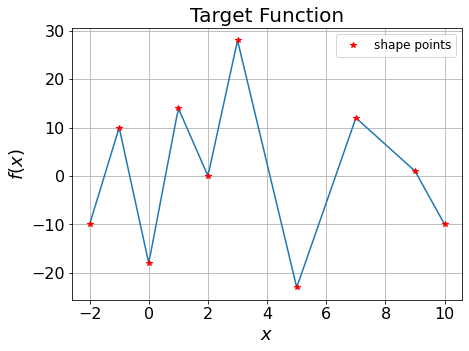

In [16]:
'''Generate the target function'''

try:    
    from engy_5310.toolkit import TargetFunction   
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

shape_pts = [(-2,-10),(-1,10),(0,-18),(1,14),(2,0),(3,28),(5,-23),(7,12),(9,1),(10,-10)]

f = TargetFunction(shape_pts, type='linear')
  
f.plot(n_plot_pts=200, show_shape_pts=True, title='Target Function')

## [Collocation Points](#toc)<a id="colpts"></a>

If $g$ is obtainable, how would we compare to $f$? On the whole $\Reals$? This prompts the simple idea of computing $g$ to approximate $f$ on a selected number of points in $\Reals$. While this may be seen as a *discretization* scheme, there is another fundamental choice a basis functions as part of the greater approximation scheme as described below which makes the overall method transcend a typical discretization scheme. Hence, let's select a number of *collocation* abscissa points and form the *set* $\{\tilde{x}_i \mid i=1,\ldots,m\}$ or vector $\tilde{\xvec}\in\Reals^m$. Now we can ask a more definite question. How do we make $g$ and $f$ to be very close when evaluated at the collocation points? Ideally if $m\rightarrow\infty$ then $f\approx g$ to a very good approximation.

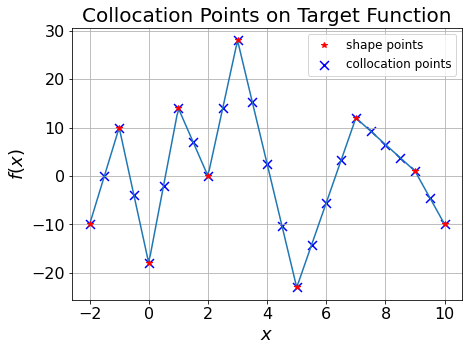

In [24]:
'''Collocation abscissa points'''
import numpy as np

min_x = shape_pts[0][0]
max_x = shape_pts[-1][0]

m = 25

x_tilde_pts = np.linspace(min_x, max_x, m)

f.plot(n_plot_pts=200, show_x_pts=x_tilde_pts, show_shape_pts=True, title='Collocation Points on Target Function')

## [Lagrange Polynomial Basis Functions w/ Least-Squares Residual](#toc)<a id="lagrange-lsq"></a>

Using the method of residual minimization of a linear combination of basis functions, compute an approximant to the given function $f:\Reals\rightarrow \Reals$.

### [Linear Combination of Non-Linear Basis Functions](#toc)<a id="lagrange-lincomb"></a>

A Lagrange polynomial, $L_k:[-1,1]\rightarrow\Reals$, basis functions can also be used

\begin{equation*}
   V := \{L_k \, \mid \, k=0,\ldots,N\} ,
\end{equation*}

where $N$ is the degree of the basis. This set of basis functions is much less flexible than the Fourier counterpart, unless the function to be approximated is a polynomial function. There are multiple ways to generate Lagrange polynomials, here is the most practical:

\begin{align*}
 L_0(\hat{x}) &= 1, \\
 L_1(\hat{x}) &= x, \\
 L_k(\hat{x}) &= \frac{2k-1}{k}\,\hat{x}\,L_{k-1}(\hat{x}) - \frac{k-1}{k}\,L_{k-2}(\hat{x}), \quad \forall \quad k=2,\ldots,N .
\end{align*}

where the domain of the polynomial functions can be mapped to by $\hat{x} = 2\,\frac{x - (b+a)/2}{b-a}$, when the interval of approximation of the target function is $[a,b] \in \Reals$.

In [30]:
'''Build the basis function evaluation matrix and target function vector at the collocation points'''

try:    
    from engy_5310.toolkit import build_lagrange_matrix
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
    
degree = 15

a_tilde_mtrx = build_lagrange_matrix(degree, x_tilde_pts)
f_tilde_vec = np.array(f.values(x_tilde_pts))

if a_tilde_mtrx.shape[0] > a_tilde_mtrx.shape[1]:
    print('A is overdetermined.')
elif a_tilde_mtrx.shape[0] < a_tilde_mtrx.shape[1]:
    print('A is underdetermined.')  
else:
    print('A is determined.')

A is overdetermined.


### [Optimal Combination Coefficients](#toc)<a id="lagrange-optimal-coeff"></a>

Solve the normal equations

\begin{equation*}
 \tilde{\Amtrx}^\top\tilde{\Amtrx}\,\tilde{\cvec}^* = \tilde{\Amtrx}^\top\,\tilde{\fvec} ,
\end{equation*}

which has a unique solution as long as $\tilde{\Amtrx}$ is full rank. Rank deficiency can be avoided in this approximation area by selecting proper basis functions, say orthogonal, and proper *collocation* abscissa points, say unique values.


In [31]:
'''Compute optimal coefficient vector'''

import numpy as np

try:    
    from engy_5310.toolkit import solve 
    from engy_5310.toolkit import universal_solve
    from engy_5310.toolkit import matrix_rank
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

if matrix_rank(a_tilde_mtrx) == min(a_tilde_mtrx.shape):
    print('A is full rank.')
    #c_tilde_star_vec = solve(a_tilde_mtrx.transpose()@a_tilde_mtrx, a_tilde_mtrx.transpose()@f_tilde_vec)
    c_tilde_star_vec = np.linalg.solve(a_tilde_mtrx.transpose()@a_tilde_mtrx, a_tilde_mtrx.transpose()@f_tilde_vec)
else:
    print('A is rank deficient.')
    c_tilde_star_vec = universal_solve(a_tilde_mtrx.transpose()@a_tilde_mtrx, a_tilde_mtrx.transpose()@f_tilde_vec,
                                       pivot_tol=1e-6)
    
if a_tilde_mtrx.shape[0] > a_tilde_mtrx.shape[1]:
    print('A is overdetermined.')
elif a_tilde_mtrx.shape[0] < a_tilde_mtrx.shape[1]:
    print('A is underdetermined.')  
else:
    print('A is determined.')

A is full rank.
A is overdetermined.


### [Best Approximant Function](#toc)<a id="lagrange-approximant"></a>

The best approximant non-linear function $g^*:\Reals\rightarrow\Reals$, can be built as a vector-valued function for any set of points $\xvec\in\Reals^p$,

\begin{equation*}
 \boxed{\gvec^*(\xvec) = \Amtrx(\xvec)\,\tilde{\cvec}^*} ,
\end{equation*}

where $\Amtrx(\cdot)$ is the Fourier basis functions evaluation matrix on any given $\xvec$. Note that $\gvec$ is non-linear in $\xvec$. Also note that by design,
$\gvec^*(\tilde{\xvec}) = \Amtrx(\tilde{\xvec})\,\tilde{\cvec}^* = \tilde{\Amtrx}\,\tilde{\cvec}^* = \tilde{\gvec}(\tilde{\cvec}^*)$.

In [32]:
'''Build the best approximant function'''

def g_best_vec_func(x_pts):
    return build_lagrange_matrix(degree, x_pts)@c_tilde_star_vec

### [Results](#toc)<a id="lagrange-res"></a>

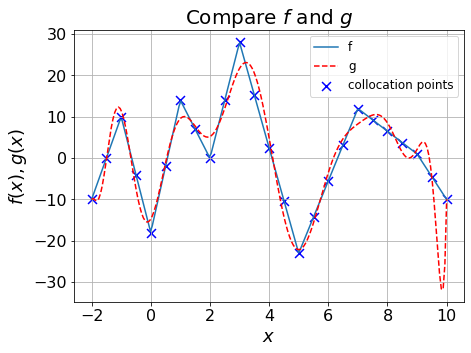

In [33]:
'''Plot comparison of f and g_vec'''

n_pts = max(2 * m, 200)
x_pts = np.linspace(min_x, max_x, n_pts)

g_vec = g_best_vec_func(x_pts)

f.plot(g=(x_pts,g_vec), n_plot_pts=n_pts, show_x_pts=x_tilde_pts, title='Compare $f$ and $g$')

### [Errors](#toc)<a id="lagrange-error"></a>

In [34]:
'''L2 norm error'''

from scipy.integrate import quad
import math

print('||f||_L2 =', f.l2_norm[0])
#print('quadrature error =', error)

def g2_integrand(x):
    g_vec = g_best_vec_func(np.array([x]))
    return g_vec**2

print('')

x_ave = (min_x + max_x)/2
x_length = max_x - min_x
min_x_hat = 2*(min_x - x_ave/2)/x_length
max_x_hat = 1.0

g2_integral, error = quad(g2_integrand, min_x_hat, max_x_hat, limit=1000)
g2_integral *= x_length/2
print('||g||_L2 =', math.sqrt(g2_integral))
#print('quadrature error =', error)

def f_minus_g_2_integrand(x_hat):
    g_vec = g_best_vec_func(np.array([x_hat]))
    x = x_hat/2*x_length + x_ave
    f_x = f.values(np.array([x]))
    return (f_x-g_vec)**2

print('')

f_minus_g_2_integral, error = quad(f_minus_g_2_integrand, min_x_hat, max_x_hat, limit=1000)
f_minus_g_2_integral *= x_length/2
print('||f-g||_L2 =', math.sqrt(f_minus_g_2_integral))
#print('quadrature error =', error)

print('')
print('Relative error [%] =', math.sqrt(f_minus_g_2_integral)/f.l2_norm[0]*100)

||f||_L2 = 37.09896674212549

||g||_L2 = 39.37924529507501

||f-g||_L2 = 14.011845817878799

Relative error [%] = 37.76883037006121


### [Residual](#toc)<a id="lagrange-residual"></a>

**The residual vector also produces information on the goodness of the approximation.**

An important property is to count how many positive and negative values in the residual exists. A good approximation will have an even distribution of positives and negatives, that is, the function is symmetric relative to the abscissa.

Positives at collocation pts =  10
Negatives at collocation pts =  15
Positive  =  148
Negatives =  152


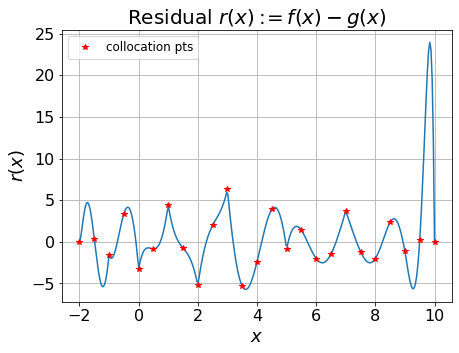

In [35]:
'''Residual of the best approximant'''

import matplotlib.pyplot as plt
%matplotlib inline

n_pts = max(4 * m, 300)
x_pts = np.linspace(min_x, max_x, n_pts)

residual = f.values(x_pts) - g_best_vec_func(x_pts)
residual_collocation_pts = f.values(x_tilde_pts) - g_best_vec_func(x_tilde_pts)
print('Positives at collocation pts = ', tuple([True for p in residual_collocation_pts if p>0]).count(True))
print('Negatives at collocation pts = ', tuple([True for p in residual_collocation_pts if p<0]).count(True))
print('Positive  = ', tuple([True for p in residual if p>0]).count(True))
print('Negatives = ', tuple([True for p in residual if p<0]).count(True))
  
plt.figure(1, figsize=(7, 5))
plt.plot(x_pts, residual)
plt.plot(x_tilde_pts, f.values(x_tilde_pts)-g_best_vec_func(x_tilde_pts),'r*',label='collocation pts')
plt.title(r'Residual $r(x) :\!\!= f(x) - g(x)$', fontsize=20)
plt.ylabel(r'$r(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()

## [Experiment #1](#toc)<a id="ex1"></a>

Using the method of residual minimization of a linear combination of basis functions, compute an approximant to the given function $f:(a,b)\in\Reals\rightarrow \Reals$.

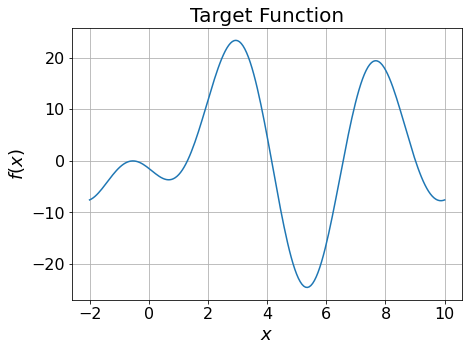

In [36]:
'''Consider another function'''

f = TargetFunction(shape_pts, type='fourier')
  
f.plot(n_plot_pts=200, title='Target Function')

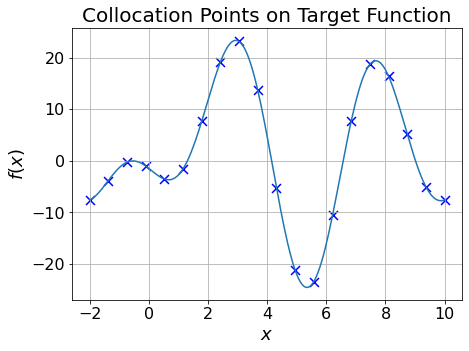

In [106]:
'''Collocation abscissa points'''
import numpy as np

min_x = shape_pts[0][0]
max_x = shape_pts[-1][0]

m = 20

x_tilde_pts = np.linspace(min_x, max_x, m)

f.plot(n_plot_pts=200, show_x_pts=x_tilde_pts, title='Collocation Points on Target Function')

In [107]:
'''Build the basis function evaluation matrix and target function vector at collocation points'''
 
degree = 8

a_tilde_mtrx = build_lagrange_matrix(degree, x_tilde_pts)
f_tilde_vec = f.values(x_tilde_pts)

if a_tilde_mtrx.shape[0] > a_tilde_mtrx.shape[1]:
    print('A is overdetermined.')
elif a_tilde_mtrx.shape[0] < a_tilde_mtrx.shape[1]:
    print('A is underdetermined.')  
else:
    print('A is determined.')

A is overdetermined.


In [108]:
'''Compute optimal coefficient vector'''

import numpy as np

try:    
    from engy_5310.toolkit import solve 
    from engy_5310.toolkit import universal_solve
    from engy_5310.toolkit import matrix_rank
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

if matrix_rank(a_tilde_mtrx) == min(a_tilde_mtrx.shape):
    print('A is full rank.')
    #c_tilde_star_vec = solve(a_tilde_mtrx.transpose()@a_tilde_mtrx, a_tilde_mtrx.transpose()@f_tilde_vec)
    c_tilde_star_vec = np.linalg.solve(a_tilde_mtrx.transpose()@a_tilde_mtrx, a_tilde_mtrx.transpose()@f_tilde_vec)
else:
    print('A is rank deficient.')
    c_tilde_star_vec = universal_solve(a_tilde_mtrx.transpose()@a_tilde_mtrx, a_tilde_mtrx.transpose()@f_tilde_vec,
                                       pivot_tol=1e-6)
    
if a_tilde_mtrx.shape[0] > a_tilde_mtrx.shape[1]:
    print('A is overdetermined.')
elif a_tilde_mtrx.shape[0] < a_tilde_mtrx.shape[1]:
    print('A is underdetermined.')  
else:
    print('A is determined.')

A is full rank.
A is overdetermined.


In [109]:
'''Build the best approximant function'''

def g_best_vec_func(x_pts):
    return build_lagrange_matrix(degree, x_pts)@c_tilde_star_vec

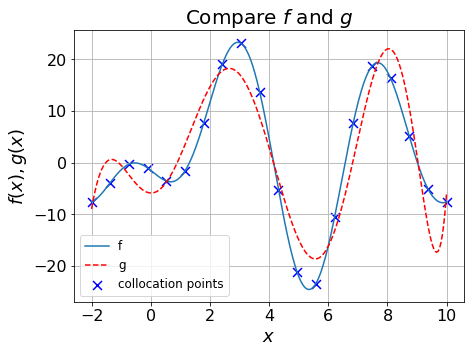

In [110]:
'''Plot comparison of f and g_vec'''

n_pts = max(2 * m, 250)
x_pts = np.linspace(min_x, max_x, n_pts)

g_vec = g_best_vec_func(x_pts)

f.plot(g=(x_pts,g_vec), n_plot_pts=n_pts, show_x_pts=x_tilde_pts, title='Compare $f$ and $g$')

In [111]:
'''L2 norm error'''

from scipy.integrate import quad
import math

print('||f||_L2 =', f.l2_norm[0])
#print('quadrature error =', error)

def g2_integrand(x):
    g_vec = g_best_vec_func(np.array([x]))
    return g_vec**2

print('')

x_ave = (min_x + max_x)/2
x_length = max_x - min_x
min_x_hat = 2*(min_x - x_ave/2)/x_length
max_x_hat = 1.0

g2_integral, error = quad(g2_integrand, min_x_hat, max_x_hat, limit=1000)
g2_integral *= x_length/2
print('||g||_L2 =', math.sqrt(g2_integral))
#print('quadrature error =', error)

def f_minus_g_2_integrand(x_hat):
    g_vec = g_best_vec_func(np.array([x_hat]))
    x = x_hat/2*x_length + x_ave
    f_x = f.values(np.array([x]))
    return (f_x-g_vec)**2

print('')

f_minus_g_2_integral, error = quad(f_minus_g_2_integrand, min_x_hat, max_x_hat, limit=1000)
f_minus_g_2_integral *= x_length/2
print('||f-g||_L2 =', math.sqrt(f_minus_g_2_integral))
#print('quadrature error =', error)

print('')
print('Relative error [%] =', math.sqrt(f_minus_g_2_integral)/f.l2_norm[0]*100)

||f||_L2 = 44.21979755232221

||g||_L2 = 41.250448120963725

||f-g||_L2 = 15.833980303806468

Relative error [%] = 35.80744639337441


Positives at collocation pts =  10
Negatives at collocation pts =  10
Positive  =  151
Negatives =  149


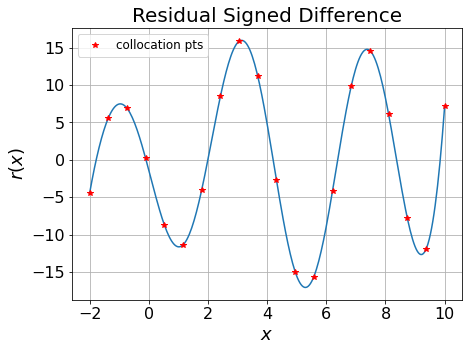

In [86]:
'''Residual of the best approximant'''

import matplotlib.pyplot as plt
%matplotlib inline

n_pts = max(4 * m, 300)
x_pts = np.linspace(min_x, max_x, n_pts)

residual = f.values(x_pts) - g_best_vec_func(x_pts)
residual_collocation_pts = f.values(x_tilde_pts) - g_best_vec_func(x_tilde_pts)
print('Positives at collocation pts = ', tuple([True for p in residual_collocation_pts if p>0]).count(True))
print('Negatives at collocation pts = ', tuple([True for p in residual_collocation_pts if p<0]).count(True))
print('Positive  = ', tuple([True for p in residual if p>0]).count(True))
print('Negatives = ', tuple([True for p in residual if p<0]).count(True))
  
plt.figure(1, figsize=(7, 5))
plt.plot(x_pts, residual)
plt.plot(x_tilde_pts, f.values(x_tilde_pts)-g_best_vec_func(x_tilde_pts),'r*',label='collocation pts')
plt.title('Residual Signed Difference', fontsize=20)
plt.ylabel(r'$r(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()